In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import soundfile

# to play the audio files
from IPython.display import Audio

In [3]:
RAV = "/content/drive/MyDrive/Speech Emotion Recognition/Phase 2/SER Model/RAVDESS"
TESS = "/content/drive/MyDrive/Speech Emotion Recognition/Phase 2/SER Model/TESS Toronto emotional speech set data"

In [4]:
# Get the data location for TESS
path = []
emotion = []
dir_list = os.listdir(TESS)

for i in dir_list:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + '/'+ i)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)

# Randomize the dataset
TESS_df = TESS_df.sample(frac=1).reset_index(drop=True)

TESS_df.head(2)

,labels,path
0,sad,/content/drive/MyDrive/Speech Emotion Recognit...
1,angry,/content/drive/MyDrive/Speech Emotion Recognit...


In [5]:
# Get the data location for RAVDESS
path =  emotion = []
females = males = []
dir_list = os.listdir(RAV)

for actor in dir_list:

    files = os.listdir(RAV +"/"+ actor)
    for file in files:
        part = file.split('.')[0]
        part = part.split("-")

        temp = int(part[6])

        if part[2] == '01':
            emotion = 'neutral'
        elif part[2] == '02':
            emotion = 'calm'
        elif part[2] == '03':
            emotion = 'happy'
        elif part[2] == '04':
            emotion = 'sad'
        elif part[2] == '05':
            emotion = 'angry'
        elif part[2] == '06':
            emotion = 'fear'
        elif part[2] == '07':
            emotion = 'disgust'
        elif part[2] == '08':
            emotion = 'surprise'
        else:
            emotion = 'unknown'

        if temp%2 == 0:
            path = (RAV + "/" + actor + '/' + file)
            #emotion = 'female_'+emotion
            females.append([emotion, path])
        else:
            path = (RAV + "/" + actor + '/' + file)
             #emotion = 'male_'+emotion
            males.append([emotion, path])


RavFemales_df = pd.DataFrame(females)
RavFemales_df.columns = ['labels', 'path']

RavMales_df = pd.DataFrame(males)
RavMales_df.columns = ['labels', 'path']

# Randomize the dataset
RavMales_df = RavMales_df.sample(frac=1).reset_index(drop=True)
RavFemales_df = RavFemales_df.sample(frac=1).reset_index(drop=True)

print('RAVDESS datasets')
RavFemales_df.head()

RAVDESS datasets


,labels,path
0,neutral,/content/drive/MyDrive/Speech Emotion Recognit...
1,happy,/content/drive/MyDrive/Speech Emotion Recognit...
2,sad,/content/drive/MyDrive/Speech Emotion Recognit...
3,happy,/content/drive/MyDrive/Speech Emotion Recognit...
4,angry,/content/drive/MyDrive/Speech Emotion Recognit...


In [6]:
# Concatenate dataframes
data = pd.concat([RavFemales_df, RavMales_df, TESS_df])

In [7]:
from sklearn.preprocessing import LabelEncoder


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
data['encoded_labels'] = label_encoder.fit_transform(data['labels'])

data.head()

,labels,path,encoded_labels
0,neutral,/content/drive/MyDrive/Speech Emotion Recognit...,5
1,happy,/content/drive/MyDrive/Speech Emotion Recognit...,4
2,sad,/content/drive/MyDrive/Speech Emotion Recognit...,6
3,happy,/content/drive/MyDrive/Speech Emotion Recognit...,4
4,angry,/content/drive/MyDrive/Speech Emotion Recognit...,0


In [8]:
import numpy as np
import time
import os
import librosa
from concurrent.futures import ThreadPoolExecutor

lst = []

def process_row(row):
    try:
        # Check if the path is a file
        if os.path.isfile(row.path):
            X, sample_rate = librosa.load(row.path)
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            label = row.encoded_labels
            return mfccs, label
    except ValueError:
        pass  # Handle the exception or simply skip the file
        return None

start_time = time.time()

# Adjust the number of threads based on your machine's capabilities
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(process_row, data.itertuples()))

# Filter out the None results (due to errors in processing)
lst = [result for result in results if result is not None]

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


--- Data loaded. Loading time: 171.8297610282898 seconds ---


In [9]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [22]:
y

array([5, 4, 6, ..., 5, 6, 5])

In [10]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2880, 40), (2880,))

##Neural network

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [12]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

x_traincnn.shape, x_testcnn.shape

((1929, 40, 1), (951, 40, 1))

In [13]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.legacy.Adam(lr=0.00005, decay=0.0)
# opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [16]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Epoch 1/400
121/121 [==============================] - 3s 16ms/step - loss: 5.4195 - accuracy: 0.1348 - val_loss: 2.3584 - val_accuracy: 0.1788
Epoch 2/400
121/121 [==============================] - 3s 22ms/step - loss: 3.9611 - accuracy: 0.1498 - val_loss: 2.0741 - val_accuracy: 0.2019
Epoch 3/400
121/121 [==============================] - 3s 22ms/step - loss: 3.1902 - accuracy: 0.1664 - val_loss: 2.2089 - val_accuracy: 0.1672
Epoch 4/400
121/121 [==============================] - 2s 16ms/step - loss: 2.8186 - accuracy: 0.1861 - val_loss: 2.0076 - val_accuracy: 0.2397
Epoch 5/400
121/121 [==============================] - 2s 15ms/step - loss: 2.5498 - accuracy: 0.1731 - val_loss: 1.8994 - val_accuracy: 0.2597
Epoch 6/400
121/121 [==============================] - 2s 14ms/step - loss: 2.3974 - accuracy: 0.1835 - val_loss: 1.9597 - val_accuracy: 0.1861
Epoch 7/400
121/121 [==============================] - 2s 14ms/step - loss: 2.2552 - accuracy: 0.1934 - val_loss: 1.9046 - val_accuracy:

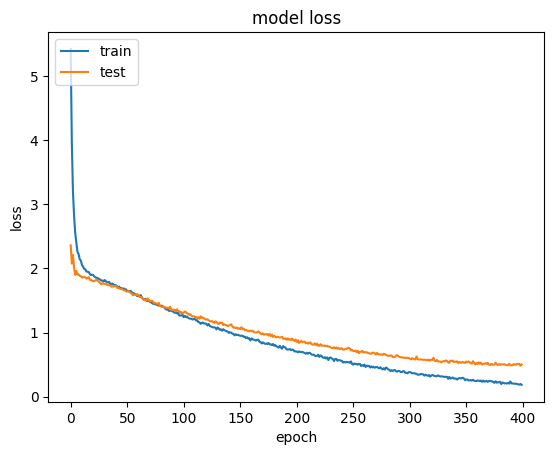

In [17]:
# original
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

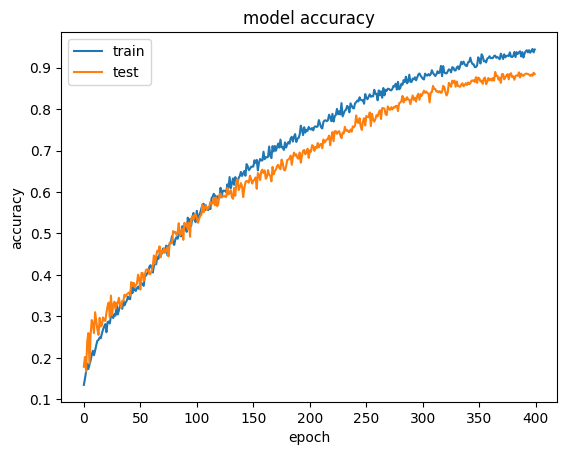

In [18]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# original

In [19]:
# predictions = model.predict_classes(x_testcnn)
predictions = np.argmax(model.predict(x_testcnn),axis=1)
predictions

30/30 [==============================] - 0s 3ms/step


array([3, 3, 7, 0, 5, 6, 2, 4, 0, 6, 2, 1, 1, 0, 3, 2, 1, 1, 4, 6, 6, 3,
       4, 6, 3, 4, 3, 6, 1, 7, 1, 6, 3, 4, 6, 4, 3, 0, 4, 0, 5, 3, 6, 2,
       1, 6, 1, 1, 1, 5, 0, 4, 6, 5, 3, 7, 2, 3, 2, 1, 4, 1, 3, 0, 6, 6,
       3, 2, 4, 7, 7, 7, 2, 3, 6, 3, 5, 4, 1, 0, 0, 2, 7, 7, 3, 2, 7, 7,
       4, 0, 0, 1, 5, 3, 3, 1, 2, 2, 7, 2, 4, 3, 4, 3, 3, 3, 0, 4, 0, 0,
       1, 2, 2, 5, 5, 6, 1, 0, 7, 7, 0, 3, 4, 4, 0, 7, 2, 0, 3, 5, 3, 3,
       4, 7, 6, 4, 3, 0, 1, 4, 0, 2, 5, 4, 0, 1, 7, 2, 1, 3, 0, 3, 6, 4,
       4, 6, 3, 0, 1, 6, 7, 6, 6, 1, 3, 1, 0, 1, 5, 1, 4, 2, 1, 0, 7, 7,
       6, 4, 7, 4, 6, 2, 7, 2, 3, 7, 6, 4, 7, 6, 7, 2, 3, 2, 4, 0, 6, 4,
       1, 0, 6, 4, 0, 0, 4, 4, 1, 5, 1, 4, 7, 6, 7, 1, 2, 4, 2, 5, 7, 5,
       5, 5, 0, 4, 2, 2, 4, 6, 2, 4, 7, 7, 2, 6, 0, 6, 4, 1, 2, 6, 1, 0,
       4, 3, 3, 0, 2, 4, 1, 4, 1, 6, 1, 7, 0, 6, 2, 7, 1, 4, 2, 3, 4, 4,
       0, 2, 4, 6, 6, 3, 6, 3, 3, 7, 1, 3, 0, 1, 4, 3, 0, 4, 7, 6, 5, 2,
       7, 2, 5, 1, 6, 7, 6, 6, 5, 3, 6, 7, 3, 2, 2,

In [ ]:
y_test

In [23]:
new_Ytest = y_test.astype(int)

In [24]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       132
           1       0.92      0.90      0.91       121
           2       0.88      0.87      0.87       123
           3       0.84      0.93      0.88       123
           4       0.89      0.89      0.89       133
           5       0.71      0.88      0.79        40
           6       0.87      0.78      0.82       136
           7       0.89      0.89      0.89       143

    accuracy                           0.88       951
   macro avg       0.87      0.88      0.88       951
weighted avg       0.89      0.88      0.88       951



In [25]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = angry, 1 = calm, 2 = disgust, 3 = fear, 4 = happy, 5 = neutral, 6 = sad, 7 = surprise

[[123   0   0   4   2   0   2   1]
 [  0 109   4   0   2   4   2   0]
 [  0   2 107   2   0   4   4   4]
 [  0   0   2 115   0   2   4   0]
 [  0   0   2   2 119   0   4   6]
 [  0   0   3   0   0  35   0   2]
 [  0   8   0  12   4   4 106   2]
 [  4   0   4   2   6   0   0 127]]
